# Group Project: How do various musical elements correlate to the number of Spotify streams?
#### Sunnie Chen, Rachel Weng, Martin Wong, Seabert Yuan
### Overview

Spotify is a digital music streaming service that allows users to access millions of songs on various devices, including computers, phones, and cars. As of 2024, Spotify is documented as the world’s most popular streaming service, with 350 million active users and 150 million premium subscribers. [(Source)](https://www.cnn.com/cnn-underscored/reviews/best-music-streaming-service#:~:text=Spotify%20is%20the%20most%20popular,users%20and%20150%20million%20subscribers.)

Our project aims to answer the following question: How does danceability, valence, beats-per-minute, and Spotify chart rankings correlate to the number of Spotify streams?
The dataset, from Kaggle, documents the most streamed Spotify songs of 2023 obtained using the Spotify API and provides an abundance of information about both the song’s background and musicality. A stream is defined by a user listening to a song for more than 30 seconds. The dataset also provides percentage values from a range of 0 - 100 % of danceability and valence. Danceability is a track’s suitability for dancing based on musical factors such as tempo, beat strength, rhythmic stability, and overall regularity. Valence describes a track’s musical positiveness; Spotify does not outline how valence is calculated. Spotify chart rankings are calculated by the number of recent streams and shares. 

## Preliminary exploratory data analysis:

In [37]:
library(tidyverse)
library(tidymodels)
library(reshape2)
library(repr)

### Reading the data from the web into R 

In [38]:
spotify_data <- read_csv("https://raw.githubusercontent.com/martin0wong/dsci100_project/main/data/spotify-2023.csv")
spotify_data

Rows: 953 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): track_name, artist(s)_name, streams, key, mode
dbl (17): artist_count, released_year, released_month, released_day, in_spot...
num  (2): in_deezer_playlists, in_shazam_charts

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


track_name                                                                                   
1   Seven (feat. Latto) (Explicit Ver.)                                                          
2   LALA                                                                                         
3   vampire                                                                                      
4   Cruel Summer                                                                                 
5   WHERE SHE GOES                                                                               
6   Sprinter                                                                                     
7   Ella Baila Sola                                                                              
8   Columbia                                                                                     
9   fukumean                                                                                     
10  La Bebe - Remix                                                                              
11  un x100to                                                                                    
12  Super Shy                                                                                    
13  Flowers                                                                                      
14  Daylight                                                                                     
15  As It Was                                                                                    
16  Kill Bill                                                                                    
17  Cupid - Twin Ver.                                                                            
18  What Was I Made For? [From The Motion Picture "Barbie"]                                      
19  Classy 101                                                                                   
20  Like Crazy                                                                                   
21  LADY GAGA                                                                                    
22  I Can See You (Taylorï¿½ï¿½ï¿½s Version) (From The                                           
23  I Wanna Be Yours                                                                             
24  Peso Pluma: Bzrp Music Sessions, Vol. 55                                                     
25  Popular (with Playboi Carti & Madonna) - The Idol Vol. 1 (Music from the HBO Original Series)
26  SABOR FRESA                                                                                  
27  Calm Down (with Selena Gomez)                                                                
28  MOJABI GHOST                                                                                 
29  Last Night                                                                                   
30  Dance The Night (From Barbie The Album)                                                      
⋮   ⋮                                                                                            
924 we fell in love in october                                                                   
925 2 Be Loved (Am I Ready)                                                                      
926 Celestial                                                                                    
927 Typa Girl                                                                                    
928 I Really Want to Stay at Your House                                                          
929 California Breeze                                                                            
930 Bamba (feat. Aitch & BIA)                                                                    
931 Casei Com a Putaria                                                                          
932 Major Distribution                                                              

### Cleaning and wrangling data into a tidy format.

In [48]:
colnames(spotify_data) <- c("track_name", "artist(s)_name", "artist_count", "released_year", "released_month", "released_day", 
                                    "in_spotify_playlists", "in_spotify_charts", "streams", "in_apple_playlists", "in_apple_charts", 
                                    "in_deezer_playlists", "in_deezer_charts", "in_shazam_charts", "bpm", "key", "mode", 
                                    "danceability_percent", "valence_percent", "energy_percent", 
                                    "acousticness_percent", "instrumentalness_percent", "liveness_percent", "speechiness_percent")
spotify_data_wrangled <- spotify_data |>
                         #avg days in a year/month searched from web
                         mutate(days_released = round((2023-released_year)*365.25 + released_month*30.436875 + released_day, 0)) |> 
                         mutate(key = recode(key, "C#" = "1", "D" = "2", "D#" = "3", "E" = "4", "F" = "5", "F#" = "6", 
                                                 "G" = "7", "G#" = "8", "A" = "9", "A#" = "10", "B" = "11")) |>
                         mutate(mode = recode(mode, "Minor" = "1", "Major" = "2")) |>
                         mutate(across(streams:mode, as.numeric)) |>
                         mutate(streams = streams/1000000) |>
                         drop_na() |>
                         #selecting all columns with numeric values for regression, removing released_xxx columns as wrangled into days_released
                         select(artist_count, in_spotify_playlists:days_released)
spotify_data_wrangled

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across(streams:mode, as.numeric)`.
Caused by warning:
! NAs introduced by coercion”


artist_count in_spotify_playlists in_spotify_charts streams   
1   2             553                 147                141.38170
2   1            1474                  48                133.71629
3   1            1397                 113                140.00397
4   1            7858                 100                800.84082
5   1            3133                  50                303.23632
6   2            2186                  91                183.70623
7   2            3090                  50                725.98011
8   1             714                  43                 58.14938
9   1            1096                  83                 95.21731
10  2            2953                  44                553.63407
11  2            2876                  40                505.67144
12  1             422                  55                 58.25515
13  1            3528                  98                387.57074
14  1            8109                  77               1163.09365
15  1            2942                  77                496.79569
16  2            2610                  40                335.22223
17  1             596                  68                363.36974
18  3             332                  26                 86.44484
19  1             516                  38                 52.13525
20  2            1313                  40                200.64722
21  3            1945                  87                115.36456
22  1             250                  26                 78.30065
23  2            7112                  77                899.18338
24  2             859                  40                 61.24529
25  1            2420                  19                429.82981
26  1            2988                 101                127.40895
27  1             864                  78                 22.58116
28  2             266                  34                 52.29427
29  3            6036                  88                843.95751
30  1            9082                  56                999.74828
⋮   ⋮            ⋮                    ⋮                 ⋮         
787 4             836                  0                159.24067 
788 1             430                  6                170.70958 
789 1            2020                  0                154.35696 
790 1            6858                  0                723.04385 
791 1            3682                  6                247.68912 
792 1            1639                  0                176.47491 
793 1             452                 10                235.54929 
794 1             991                  0                 85.55936 
795 3             869                  7                146.22349 
796 3             648                  4                187.70159 
797 2            1545                  0                154.86315 
798 3            1930                  0                191.33366 
799 1            1948                  0                253.65085 
800 1            1608                  0                223.06427 
801 2            1338                  0                170.41388 
802 1            1936                  0                218.32059 
803 2            1794                  0                141.72100 
804 2            1652                  2                198.36554 
805 1            1715                  0                177.50392 
806 2             486                  0                 71.09571 
807 2            1007                  0                112.43640 
808 1             481                  9                203.43647 
809 1            1045                  0                 93.36754 
810 2            1060                  0                106.24922 
811 1            1274                  0                181.38259 
812 1             953                  0                 91.47336 
813 1            1180                  0                121.87187 
814 2             573                  0           

### Using only training data, summarize the data in at least one table (this is exploratory data analysis).

We selected the columns in_apple_charts, bpm, danceability_percent and valence_percent as predictors for our regression model on streams.

In [47]:
spotify_split <- initial_split(spotify_data_wrangled, prop = 0.75, strata = streams)
spotify_train <- training(spotify_split)
spotify_test <- testing(spotify_split)

spotify_train

artist_count in_spotify_playlists in_spotify_charts streams   
1   1            1474                  48               133.716286
2   1            1096                  83                95.217315
3   1             422                  55                58.255150
4   3             332                  26                86.444842
5   1             516                  38                52.135248
6   3            1945                  87               115.364561
7   1            2988                 101               127.408954
8   1             864                  78                22.581161
9   1            2259                  59                57.876440
10  1             148                  24                39.578178
11  2            1004                  35                54.266102
12  1             370                  20                43.857627
13  1             139                  17                39.228929
14  2             641                  50                58.054811
15  1             804                  25                95.131998
16  1              31                  39                38.411956
17  1            2000                  46               127.567540
18  1              77                  35                29.562220
19  1             266                  27                77.309611
20  2              58                  18                39.058561
21  3            1094                  34                90.839753
22  2             763                  26                 0.002762
23  2             871                  32                66.902503
24  1             451                  33                96.273746
25  5             182                   8                54.225632
26  4             283                   7                81.102253
27  2             293                   8                11.956641
28  3             727                  16                94.186466
29  1              67                   8                47.956378
30  1              86                  11                30.343206
⋮   ⋮            ⋮                    ⋮                 ⋮         
583 4            12043                 0                 863.7566 
584 1             4731                 0                 797.4023 
585 2            22923                 0                1695.7120 
586 2            33966                 0                1210.5995 
587 2            31762                 0                 843.3090 
588 1            30427                 7                1202.7227 
589 2            19067                 0                 675.0395 
590 1            33206                 1                1929.7703 
591 2            17115                 0                 918.9154 
592 2            15010                 2                2484.8129 
593 2             4890                20                 759.2088 
594 1             5415                32                 682.4752 
595 1             9833                 0                 797.1961 
596 1            50887                34                1970.6733 
597 1             3257                 0                 665.7656 
598 2            23375                21                2204.0807 
599 2            28032                 0                2591.2243 
600 1            11985                 0                 924.1933 
601 1            12382                 0                1714.4910 
602 1             8429                 1                 807.0159 
603 3            52898                 0                 933.8156 
604 1            22730                 5                2123.3097 
605 1             9021                 0                 723.8945 
606 2             9539                15                1304.3140 
607 1            13101                 9                1284.9426 
608 1            10211                 0                1122.3644 
609 1            19806                 7                 703.3017 
610 1            30992                 6           

### Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis).

We first plot all columns on the x axis and the number of streams on spotify on the y-axis to visualize how relevant would the other variables be compared to the number of streams.

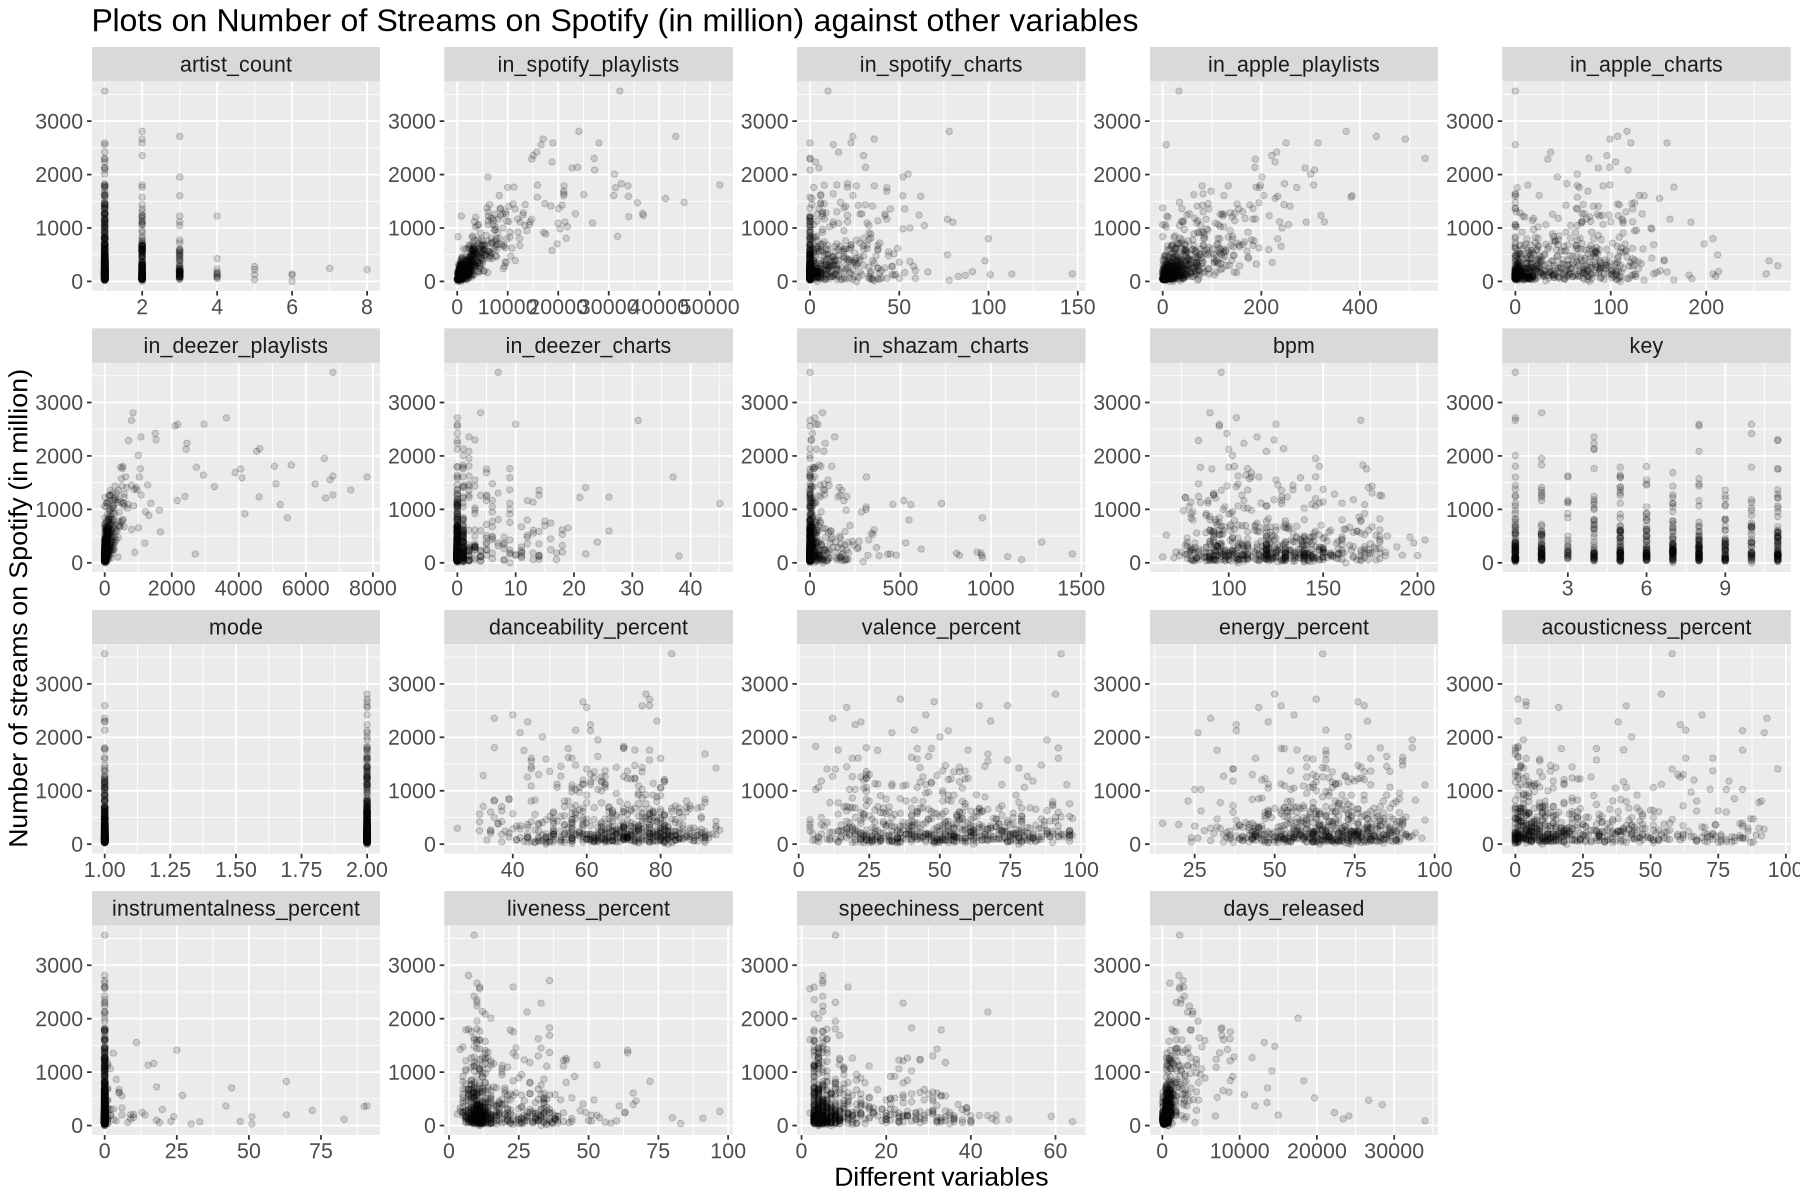

In [46]:
options(repr.plot.height = 10, repr.plot.width = 15)
spotify_train_plot <- spotify_train |> melt("streams")

ggplot(spotify_train_plot, aes(value, streams)) + 
  geom_point(alpha = 0.15) + 
  labs(x = "Different variables" ,y = "Number of streams on Spotify (in million)", 
       title = "Plots on Number of Streams on Spotify (in million) against other variables") +
  theme(text = element_text(size = 16)) +
  facet_wrap(~variable, scales = "free")
